In [0]:
import os

import numpy as np
import pandas as pd

from PIL import Image
import cv2

import matplotlib
import matplotlib.pyplot as plt

In [0]:
!wget https://datasets.d2.mpi-inf.mpg.de/MPIIGaze/MPIIGaze.tar.gz

In [0]:
!tar xvzf MPIIGaze.tar.gz MPIIGaze

In [0]:
database_path = "/content/MPIIGaze"

In [0]:
!ls $database_path/

In [0]:
def load_image_data(patient_name):
    global database_path

    annotation_path = os.path.join(database_path, "Annotation Subset", patient_name + ".txt")
    data_folder = os.path.join(database_path, "Data", "Original", patient_name)
    
    annotation = pd.read_csv(annotation_path, sep=" ", header=None)
    
    points = np.array(annotation.loc[:, list(range(1, 17))])
    
    filenames = np.array(annotation.loc[:, [0]]).reshape(-1)
    images = [np.array(Image.open(os.path.join(data_folder, filename))) for filename in filenames]
    
    return images, points

In [0]:
images, points = load_image_data("p00")

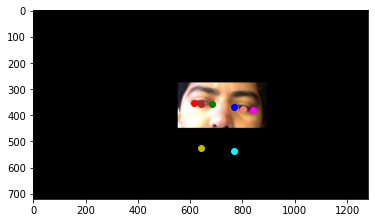

In [0]:
plt.imshow(images[0])
colors = ["r", "g", "b", "magenta", "y", "cyan", "brown", "lightcoral"]
for i in range(0, len(points[0]), 2):
    x, y = points[0, i:i+2]
    plt.scatter([x], [y], c=colors[i//2])

In [0]:
def distance(x1, y1, x2, y2):
    return int(((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5)

In [0]:
distance(0, 0, 0, 1)

1

In [0]:
image_shape = (16, 32)

In [0]:
def handle_eye(image, p1, p2, pupil):
    global image_shape

    line_len = distance(*p1, *p2)
    # x, y -> y, x
    p1 = p1[::-1]
    p2 = p2[::-1]
    pupil = pupil[::-1]
    
    corner1 = p1 - np.array([line_len//4, 0])
    corner2 = p2 + np.array([line_len//4, 0])
    
    sub_image = image[corner1[0]:corner2[0]+1, corner1[1]:corner2[1]+1]
    
    pupil_new = pupil - corner1
    pupil_new = pupil_new / sub_image.shape[:2]
    
    sub_image = cv2.resize(sub_image, image_shape[::-1], interpolation=cv2.INTER_AREA)
    sub_image = cv2.cvtColor(sub_image, cv2.COLOR_RGB2GRAY)
    
    return sub_image, pupil_new

In [0]:
def image_to_train_data(image, points):
    eye_right_p1 = points[0:2]
    eye_right_p2 = points[2:4]
    eye_right_pupil = points[12:14]
    
    right_image, right_pupil = handle_eye(image, eye_right_p1, eye_right_p2, eye_right_pupil)
    
    eye_left_p1 = points[4:6]
    eye_left_p2 = points[6:8]
    eye_left_pupil = points[14:16]
    
    left_image, left_pupil = handle_eye(image, eye_left_p1, eye_left_p2, eye_left_pupil)
    
    return right_image, right_pupil, left_image, left_pupil

In [0]:
right_image, right_pupil, left_image, left_pupil = image_to_train_data(images[10], points[10])

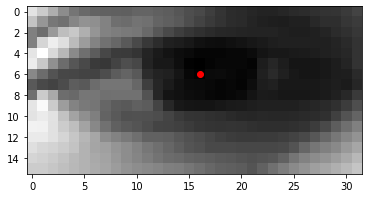

In [0]:
plt.imshow(right_image, cmap="gray")

r_p_x = int(right_pupil[1] * image_shape[1])
r_p_y = int(right_pupil[0] * image_shape[0])
plt.scatter([r_p_x], [r_p_y], c="red")

In [0]:
right_pupil.shape

(2,)

In [0]:
images_left_conc = []
images_right_conc = []
pupils_left_conc = []
pupils_right_conc = []

patients_path = os.path.join(database_path, "Data", "Original")
for patient in os.listdir(patients_path):
    print(patient)
    images, points = load_image_data(patient)
    for i in range(len(images)):
        signle_image_data = image_to_train_data(images[i], points[i])

        if any(stuff is None for stuff in signle_image_data):
            continue
        
        right_image, right_pupil, left_image, left_pupil = signle_image_data
        
        if any(right_pupil < 0) or any(left_pupil < 0):
            continue
        
        images_right_conc.append(right_image)
        images_left_conc.append(left_image)
        pupils_right_conc.append(right_pupil)
        pupils_left_conc.append(left_pupil)

images_left_conc = np.array(images_left_conc)
images_right_conc = np.array(images_right_conc)
pupils_left_conc = np.array(pupils_left_conc)
pupils_right_conc = np.array(pupils_right_conc)

p03
p05
p00
p04
p07
p01
p10
p09
p12
p02
p08
p06
p13
p11
p14


In [0]:
images_left_conc = images_left_conc / 255
images_right_conc = images_right_conc / 255

In [0]:
images_left_conc.shape, images_right_conc.shape

((10586, 16, 32), (10586, 16, 32))

In [0]:
images_left_conc.min(), images_left_conc.max()

(0.0, 1.0)

In [0]:
pupils_left_conc.shape

(10586, 2)

In [0]:
pupils_conc = np.zeros_like(pupils_left_conc)
for i in range(2):
    pupils_conc[:, i] = (pupils_left_conc[:, i] + pupils_right_conc[:, i]) / 2

In [0]:
pupils_conc.shape

(10586, 2)

In [0]:
pupils_conc.min(), pupils_conc.max()

(0.0, 0.6895928462709284)

In [0]:
viz_pupils = np.zeros(image_shape)
for y, x in pupils_conc:
    y = int(y * image_shape[0])
    x = int(x * image_shape[1])
    viz_pupils[y, x] += 1
max_val = viz_pupils.max()
viz_pupils = viz_pupils / max_val

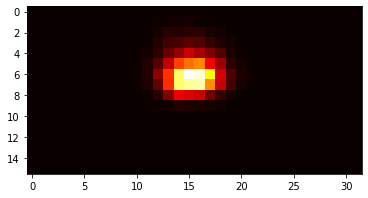

In [0]:
plt.imshow(viz_pupils, cmap="hot")

## preprocessing

In [0]:
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset

In [0]:
def make_2eyes_datasets(images_left, images_right, pupils, train_size=0.8):
    n, height, width = images_left.shape
    
    images_left = images_left.reshape(n, 1, height, width)
    images_right = images_right.reshape(n, 1, height, width)
    
    images_left_train, images_left_val, images_right_train, images_right_val, pupils_train, pupils_val = train_test_split(
        images_left, images_right, pupils, train_size=train_size
    )
    
    def make_dataset(im_left, im_right, pups):
        return TensorDataset(
            torch.from_numpy(im_left.astype(np.float32)), torch.from_numpy(im_right.astype(np.float32)), torch.from_numpy(pups.astype(np.float32))
        )
    
    train_dataset = make_dataset(images_left_train, images_right_train, pupils_train)
    val_dataset = make_dataset(images_left_val, images_right_val, pupils_val)
    
    return train_dataset, val_dataset

In [0]:
def make_dataloaders(train_dataset, val_dataset, batch_size=256):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
    return train_dataloader, val_dataloader

In [0]:
batch_size = 256

In [0]:
eyes_datasets = make_2eyes_datasets(images_left_conc, images_right_conc, pupils_conc)

In [0]:
eyes_train_loader, eyes_val_loader = make_dataloaders(*eyes_datasets, batch_size=batch_size)

## model

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
import torchvision.models as models

In [0]:
def train(model, train_loader, test_loader, epochs, lr, folder="gazenet"):
    os.makedirs(folder, exist_ok=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    for epoch in range(epochs):
        running_loss = 0
        error_mean = []
        error_std = []
        for i, (*xs_batch, y_batch) in enumerate(train_loader):
            xs_batch = [x_batch.cuda() for x_batch in xs_batch]
            y_batch = y_batch.cuda()

            optimizer.zero_grad()

            y_batch_pred = model(*xs_batch)
            loss = mse(y_batch_pred, y_batch)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            difference = (y_batch - y_batch_pred).detach().cpu().numpy().reshape(-1)
            error_mean.append(np.mean(difference))
            error_std.append(np.std(difference))

        error_mean = np.mean(error_mean)
        error_std = np.mean(error_std)

        print(f"Epoch {epoch+1}/{epochs}, train loss: {running_loss}, error mean: {error_mean}, error std: {error_std}")

        running_loss = 0
        error_mean = []
        error_std = []
        for i, (*xs_batch, y_batch) in enumerate(train_loader):
            xs_batch = [x_batch.cuda() for x_batch in xs_batch]
            y_batch = y_batch.cuda()

            y_batch_pred = model(*xs_batch)
            loss = mse(y_batch_pred, y_batch)

            loss.backward()
            running_loss += loss.item()

            difference = (y_batch - y_batch_pred).detach().cpu().numpy().reshape(-1)
            error_mean.append(np.mean(difference))
            error_std.append(np.std(difference))

        error_mean = np.mean(error_mean)
        error_std = np.mean(error_std)

        print(f"Epoch {epoch+1}/{epochs}, val loss: {running_loss}, error mean: {error_mean}, error std: {error_std}")

        epoch_path = os.path.join(folder, f"epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), epoch_path)

In [0]:
class Reshaper(nn.Module):
    def __init__(self, target_shape):
        super(Reshaper, self).__init__()
        self.target_shape = target_shape
    
    def forward(self, input):
        return torch.reshape(input, (-1, *self.target_shape))

In [0]:
class EyesNet(nn.Module):
    def __init__(self):
        super(EyesNet, self).__init__()
        
        self.features_left = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            Reshaper([64])
        )
        self.features_right = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            Reshaper([64])
        )
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 2),
            nn.Sigmoid()
        )
    
    def forward(self, x_left, x_right):
        x_left = self.features_left(x_left)
        x_right = self.features_right(x_right)
        x = torch.cat((x_left, x_right), 1)
        x = self.fc(x)
        
        return x

In [0]:
for left, right, y in eyes_train_loader:
    break

In [0]:
left.shape

torch.Size([256, 1, 16, 32])

In [0]:
right.shape

torch.Size([256, 1, 16, 32])

In [0]:
eyesnet = EyesNet().cuda()

In [0]:
train(eyesnet, eyes_train_loader, eyes_val_loader, 300, 1e-3, "eyes_net")

### EyesNet

`299 epochs -> lr = 1e-3`

Epoch 299/300, val loss: 0.004163481352406961, error mean: -0.001996406354010105, error std: 0.010547727346420288

In [0]:
eyesnet.load_state_dict(torch.load("eyes_net/epoch_299.pth"))

<All keys matched successfully>

In [0]:
import random

In [0]:
def show_output(model, data_loader, batch_num=0, samples=5, grid_shape=(5, 1), figsize=(10, 10)):
    for i, (*xs, y) in enumerate(data_loader):
        if i == batch_num:
            break
    xs = [x.cuda() for x in xs]
    y_pred = model(*xs).detach().cpu().numpy().reshape(-1, 2)
    
    xs = [x.detach().cpu().numpy().reshape(-1, 16, 32) for x in xs]
    imgs_conc = np.hstack(xs)
    y = y.cpu().numpy().reshape(-1, 2)
    
    indices = random.sample(range(len(y_pred)), samples)
    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    for i, index in enumerate(indices):
        row = i // grid_shape[1]
        column = i % grid_shape[1]
        
        axes[row, column].imshow(imgs_conc[index])
        axes[row, column].scatter([y_pred[index, 1]*32, y_pred[index, 1]*32], [y_pred[index, 0]*16, (y_pred[index, 0]+1)*16], c="r")
        axes[row, column].scatter([y[index, 1]*32, y[index, 1]*32], [y[index, 0]*16, (y[index, 0]+1)*16], c="g")

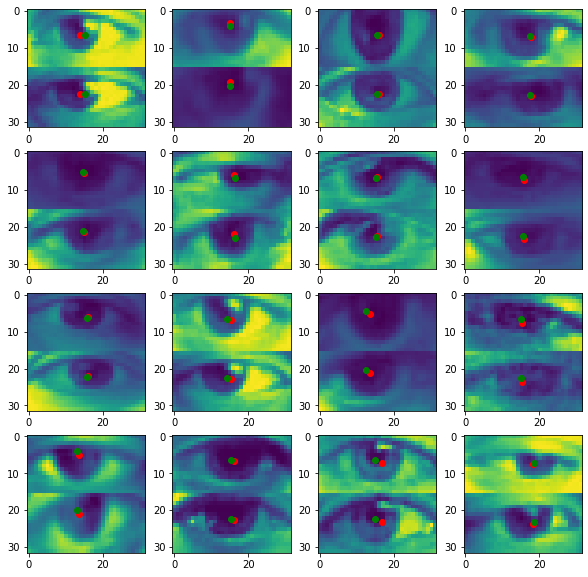

In [0]:
show_output(eyesnet, eyes_val_loader, 103, 16, (4, 4))

In [0]:
def error_distribution(model, data_loader, image_shape=(16, 32), bins=32, digits=2, figsize=(10,10)):
    ys_true = []
    ys_pred = []
    for *xs, y in data_loader:
        xs = [x.cuda() for x in xs]
        y_pred = model(*xs)
        
        ys_true.append(y.detach().cpu().numpy())
        ys_pred.append(y_pred.detach().cpu().numpy())
    ys_true = np.concatenate(ys_true)
    ys_pred = np.concatenate(ys_pred)
    indices = np.arange(len(ys_true))
    
    fig, axes = plt.subplots(2, figsize=figsize)
    for ax_num in range(2):
        ys_true_subset = ys_true[:, ax_num]
        ys_pred_subset = ys_pred[:, ax_num]
        counts, ranges = np.histogram(ys_true_subset, bins=bins)

        errors = []
        labels = []
        for i in range(len(counts)):
            begin, end = ranges[i], ranges[i + 1]
            range_indices = indices[(ys_true_subset >= begin) & (ys_true_subset <= end)]

            diffs = np.abs(ys_pred_subset[range_indices] - ys_true_subset[range_indices])
            label = (begin + end) / 2
            if image_shape:
                diffs = diffs * image_shape[ax_num]
                label = label * image_shape[ax_num]
            else:
                label = round(label, digits)
            errors.append(diffs)
            labels.append(str(label)[:2+digits])

        axes[ax_num].boxplot(errors, labels=labels)

        if image_shape:
            y_label = "difference, px"
            x_label = "true position, px"
        else:
            y_label = "difference"
            x_label = "true position"
        axes[ax_num].set_ylabel(y_label)
        axes[ax_num].set_xlabel(x_label)
        
        if ax_num == 0:
            title = "Y"
        else:
            title = "X"
        axes[ax_num].set_title(title)

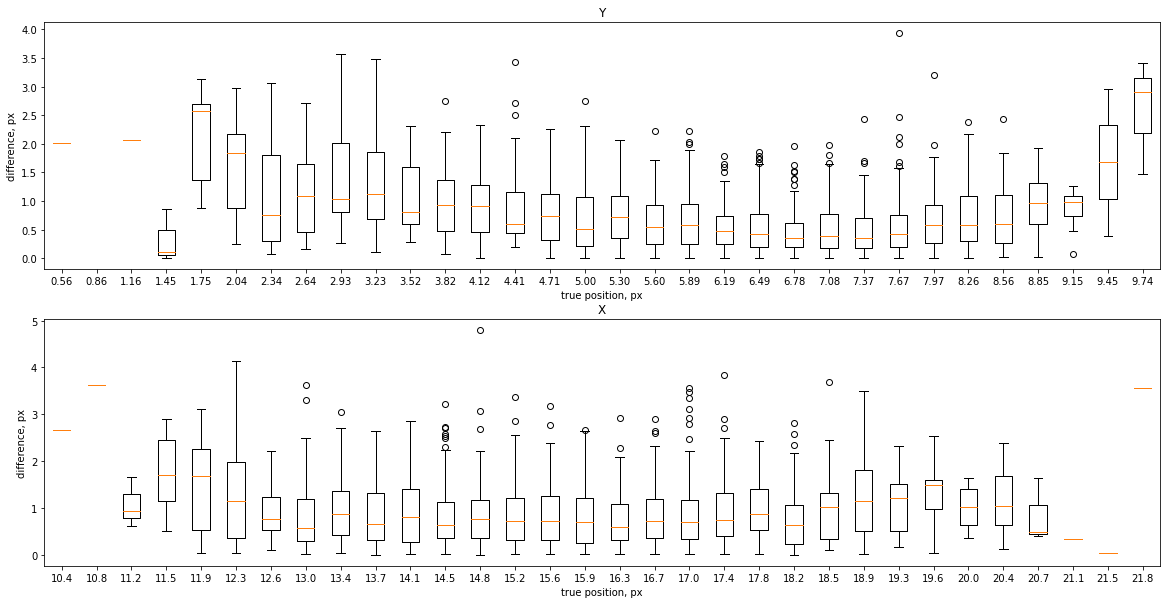

In [0]:
error_distribution(eyesnet, eyes_val_loader, figsize=(20, 10))

In [0]:
eyesnet_cpu = EyesNet().cpu()
eyesnet_cpu.load_state_dict(torch.load("eyes_net/epoch_299.pth", map_location="cpu"))

<All keys matched successfully>

In [0]:
import time

In [0]:
def measure_time(model, data_loader, n_batches=5):
    begin_time = time.time()

    batch_num = 0
    n_samples = 0

    predicted = []
    for *xs, y in data_loader:
        xs = [x.cpu() for x in xs]

        y_pred = model(*xs)
        predicted.append(y_pred.detach().cpu().numpy().reshape(-1))

        batch_num += 1
        n_samples += len(y)

        if batch_num >= n_batches:
            break
    
    end_time = time.time()

    time_per_sample = (end_time - begin_time) / n_samples
    return time_per_sample

In [0]:
_, eyes_val_loader_single = make_dataloaders(*eyes_datasets, batch_size=1)

In [0]:
tps = measure_time(eyesnet_cpu, eyes_val_loader_single)

In [0]:
print(f"{tps} seconds per sample")

0.003347921371459961 seconds per sample


VGG16-based model

In [0]:
class VGG16Based(nn.Module):
    def __init__(self):
        super(VGG16Based, self).__init__()
        
        self.vgg = models.vgg16(pretrained=False)
        self.vgg.classifier = nn.Sequential(
            nn.Linear(25088, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 2),
            nn.Sigmoid()
        )
    
    def forward(self, x_left, x_right):
        x_mid = (x_left + x_right) / 2
        x = torch.cat((x_left, x_mid, x_right), dim=1)

        x_pad = torch.zeros((x.shape[0], 3, 32, 32))
        x_pad[:, :, :16, :] = x

        x = self.vgg(x_pad)
        
        return x

In [0]:
vgg16 = VGG16Based()

In [0]:
vgg16_tps = measure_time(vgg16, eyes_val_loader_single)

In [0]:
print(f"{vgg16_tps} seconds per sample")

0.0201509952545166 seconds per sample


In [0]:
torch.save(vgg16.state_dict(), "vgg16.pt")